## Lecture 2

We want to study data cleaning, data transformation, data integration and data reduction on a dataset about human resources. By processing the data, we can mine it for information. The information might help us discover answers to questions like 

- Does the length of the short answer response correlate with years of professional experience?
- Do employees with experience in math have experience in statistics and vice versa?
- Does the company appear to have more expertise in some programming languages. For example, do we commonly find experience with both Python and R?


In [1]:
# importing some packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# changing some settings

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)

%matplotlib inline
plt.rcParams['figure.figsize'] = (9,7)

We will be working with employee surveys.

In [2]:
survey = pd.read_csv("survey.csv")
survey

,cycle,id,cs_python,cs_java,...,profile_6,profile_7,len_answer,experience
0,Summer,1,1,0,...,3,6,74,"None, I just finished my undergrad!"
1,Spring,2,1,1,...,3,8,597,"None, I just finished my undergrad!"
2,Fall,3,0,0,...,9,9,548,"5+ years, I'm a veteran!"
3,Spring,4,0,0,...,6,8,954,"5+ years, I'm a veteran!"
4,Fall,5,0,0,...,6,7,612,"2-5 years, I'm getting good at what I do!"
...,...,...,...,...,...,...,...,...,...
153,Spring,154,1,1,...,8,10,265,"5+ years, I'm a veteran!"
154,Summer,155,1,1,...,1,2,402,"None, I just finished my undergrad!"
155,Fall,156,1,1,...,1,5,555,"< 2 years, I'm fresh!"
156,Summer,157,1,0,...,1,4,0,"None, I just finished my undergrad!"


### Data Processing

We can take a look at the headers of the columns

In [3]:
survey.columns

Index(['cycle', 'id', 'cs_python', 'cs_java', 'cs_c', 'cs_perl',
       'cs_javascript', 'cs_r', 'cs_sas', 'profile_1', 'profile_2',
       'profile_3', 'profile_4', 'profile_5', 'profile_6', 'profile_7',
       'len_answer', 'experience'],
      dtype='object')

Note that 'profile_1', 'profile_2', 'profile_3', 'profile_4', 'profile_5', 'profile_6', 'profile_7' refer to educational background. 

In [8]:
profile_mapping = {1:'Viz',
                   2:'CS',
                   3:'Math',
                   4:'Stats',
                   5:'ML',
                   6:'Bus',
                   7:'Com'}

We can replace the headers to make them more descriptive.

In [12]:
new_headers = []

for header in survey.columns:
    if not "profile" in header:
        new_headers.append(header)
    else:
        new_header = profile_mapping[int(header.split("_")[1])]
        new_headers.append(new_header)

survey.columns = new_headers

,cycle,id,cs_python,cs_java,...,Bus,Com,len_answer,experience
0,Summer,1,1,0,...,3,6,74,"None, I just finished my undergrad!"
1,Spring,2,1,1,...,3,8,597,"None, I just finished my undergrad!"
2,Fall,3,0,0,...,9,9,548,"5+ years, I'm a veteran!"
3,Spring,4,0,0,...,6,8,954,"5+ years, I'm a veteran!"
4,Fall,5,0,0,...,6,7,612,"2-5 years, I'm getting good at what I do!"
...,...,...,...,...,...,...,...,...,...
153,Spring,154,1,1,...,8,10,265,"5+ years, I'm a veteran!"
154,Summer,155,1,1,...,1,2,402,"None, I just finished my undergrad!"
155,Fall,156,1,1,...,1,5,555,"< 2 years, I'm fresh!"
156,Summer,157,1,0,...,1,4,0,"None, I just finished my undergrad!"


Note that the `experience` column contains categorical data. We can encode the experience levels with numbers to aggregate the different experience levels.

In [21]:
experience_mapper = {'None, I just finished my undergrad!': 0,
 "5+ years, I'm a veteran!": 1,
 "2-5 years, I'm getting good at what I do!": 2,
 "< 2 years, I'm fresh!": 3}

survey["experience_encoded"] = survey["experience"].replace(experience_mapper)

Note that the `id` column is redundant. We can drop it from the table.

In [22]:
survey = survey.drop(columns = "id")

We can generate a histogram of the values in `len_answer` corresponding to the length of responses to a short answer question.

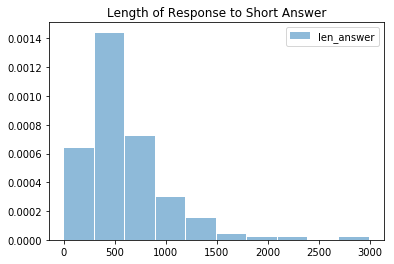

In [33]:
plt.hist(survey["len_answer"], density = True, rwidth = 0.97, alpha = 0.5, label = "len_answer")
plt.title("Length of Response to Short Answer")
plt.legend();

We can calculate the interquartile range.

In [26]:
percentile_75 = np.percentile(survey["len_answer"], 75)
percentile_25 = np.percentile(survey["len_answer"], 25)

Now we can filter the rows of the table.

In [27]:
mask = (survey["len_answer"] >= percentile_25) & (survey["len_answer"] <= percentile_75)
survey_filtered = survey[mask].copy()

Note that we removed 80 records.

In [28]:
print(len(survey))
print(len(survey_filtered))

158
78


If we want to compare attributes across different levels of experience, then we can group by the values in `experience`.

In [30]:
survey_filtered_grouped = survey_filtered[['len_answer', 'experience']].groupby(['experience']).agg({"len_answer" : ['mean', 'std', 'count']})
survey_filtered_grouped

len_answer                  
                                                 mean         std count
experience                                                             
2-5 years, I'm getting good at what I do!  546.625000  109.173180    16
5+ years, I'm a veteran!                   508.833333  116.940013     6
< 2 years, I'm fresh!                      523.363636  123.707237    22
None, I just finished my undergrad!        482.000000  101.664928    34

### Testing Guesses 

Visually, we can see a potential split between the [0, 2] year experience range and the [2+] experience range. 

We can perform a permuation test to check the statistical significance of the difference in answer length.

In [50]:
survey_filtered["experience_two_years"] = (survey_filtered["experience_encoded"] > 1).astype(int)

survey_filtered.groupby(['experience_two_years']).agg({"len_answer" : ['mean']})

,len_answer
,mean
experience_two_years,
0,486.025000
1,533.157895


In [48]:
replications = 1000

test_statistics = []
for replication in range(replications):
    shuffled = survey_filtered["experience_two_years"].sample(frac = 1, replace = True)
    survey_filtered["shuffled"] = shuffled.values
    means = survey_filtered.groupby(['shuffled']).agg({"len_answer" : ['mean']})
    test_statistics.append(means.values[1,0] - means.values[0,0])